In [3]:
%cd ..

/Users/shtosti/Dropbox/study/UZH/SS24/ML_NLP2/SwissTextSDG


/Users/shtosti/opt/anaconda3/envs/SwissSDG/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import torch
import pandas as pd
from src.data.dataset import TrainSwissTextDataset
from src.data.preprocessor import TrainSwissTextPreprocessor
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
def plot_class_distribution(df, dataset_name):
    sns.set_style("whitegrid")
    plt.figure(figsize=(7, 4), facecolor='lightgrey')
    sns.countplot(data=df, x='sdg', order=df.sdg.value_counts().index, color='seagreen', edgecolor='darkgreen')

    font = "Georgia"
    plt.title(f'Distribution of classes: {dataset_name}', fontname=font, fontsize=18)
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.xticks(rotation=90, fontname=font)
    plt.yticks(fontname=font)

    plt.show()

    return 

5635 11443 0


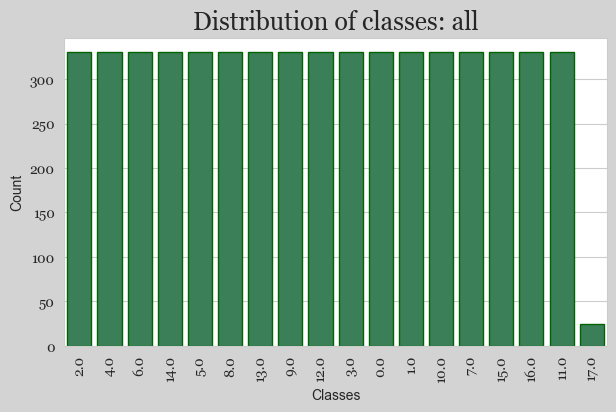

In [4]:
# Instantiate the dataset
dataset_name = 'all'
dataset = TrainSwissTextDataset.create_instance(dataset=dataset_name, model_name='mbert', use_val=False)

train_df, test_df, val_df = dataset.get_train_test_val()
print(len(train_df), len(test_df), len(val_df))

plot_class_distribution(df=train_df, dataset_name=dataset_name)

142 290 0


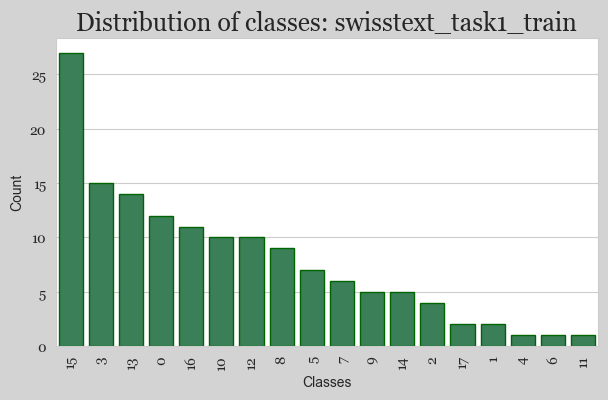

In [5]:
# Instantiate the dataset
dataset_name = 'swisstext_task1_train'
dataset = TrainSwissTextDataset.create_instance(dataset=dataset_name, model_name='mbert', use_val=False)

train_df, test_df, val_df = dataset.get_train_test_val()
print(len(train_df), len(test_df), len(val_df))

plot_class_distribution(df=train_df, dataset_name=dataset_name)

-------

________
# Correlation between Confidence, Performance and Class size

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_confidence_to_performance(csv_files, model_names):
    num_files = len(csv_files)

    fig, axes = plt.subplots(nrows=num_files, ncols=1, figsize=(10, 17))
    fig.suptitle('Correctness of Predictions vs Confidence\n', fontsize=16)

    for i, (csv_file, model_name) in enumerate(zip(csv_files, model_names)):
        data = pd.read_csv(csv_file)

        # compute correlation
        correlation = data['labels'].corr(data['prediction_proba'])

        # Plot the data
        ax = axes[i] if num_files > 1 else axes
        correct_pred = data['labels'] == data['predictions']
        ax.scatter(data['prediction_proba'][correct_pred], data['labels'][correct_pred], color='green', label='Correct Prediction', alpha=0.5)
        ax.scatter(data['prediction_proba'][~correct_pred], data['labels'][~correct_pred], color='red', label='Incorrect Prediction', alpha=0.5)

        ax.set_title(f'{model_name}', fontsize=12)
        ax.set_xlabel('Confidence / prediction probability')
        ax.set_ylabel('Class Label')
        ax.set_yticks(range(18)) # adjust the y-ticks
        ax.grid(True)

        ax.text(
                0.05, 0.90, 
                f'Correlation: {correlation:.2f}', 
                transform=ax.transAxes, 
                fontsize=10,
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
                )
                
    ax.legend()

    plt.tight_layout()
    plt.show()

    return


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_confidence_to_size(csv_files, model_names):
    num_files = len(csv_files)

    for csv_file in csv_files:
        data = pd.read_csv(csv_file)
        min_proba = 0
        max_proba = 1

    common_xlim = (min_proba, max_proba) # set common scale on x 

    fig, axes = plt.subplots(nrows=num_files, ncols=1, figsize=(7, 14))
    fig.suptitle('Class Size vs Confidence\n', fontsize=16)

    for i, (csv_file, model_name) in enumerate(zip(csv_files, model_names)):
        data = pd.read_csv(csv_file)
        class_size = data['labels'].value_counts().sort_index()

        mean_proba = data.groupby('labels')['prediction_proba'].mean()
        df = pd.DataFrame({'class_size': class_size, 'mean_proba': mean_proba})

        correlation = df['class_size'].corr(df['mean_proba'])

        ax = axes[i] if num_files > 1 else axes
        ax.scatter(df['mean_proba'], df['class_size'], alpha=0.5)

        ax.set_title(f'{model_name}', fontsize=12)
        ax.set_xlabel('Mean Prediction Probability')
        ax.set_ylabel('Class Size')
        ax.set_xlim(common_xlim)  # Set common x-axis range
        ax.grid(True)

        ax.text(0.05, 0.90, f'Correlation: {correlation:.2f}', transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

    return


In [8]:
def plot_f1_to_size(csv_files, model_names):
    num_files = len(csv_files)

    # Initialize variables to store min and max F1 scores
    min_f1 = float('inf')
    max_f1 = float('-inf')
    for csv_file in csv_files:
        data = pd.read_csv(csv_file)
        f1_scores = (data['labels'] == data['predictions']).astype(int).groupby(data['labels']).mean()
        min_f1 = min(min_f1, f1_scores.min())
        max_f1 = max(max_f1, f1_scores.max())

    # add space around the plot
    buffer = 0.1 * (max_f1 - min_f1)
    common_ylim = (min_f1 - buffer, max_f1 + buffer)

    fig, axes = plt.subplots(nrows=num_files, ncols=1, figsize=(7, 14))
    fig.suptitle('Class Size vs average per-class F1 Score\n', fontsize=16)

    for i, (csv_file, model_name) in enumerate(zip(csv_files, model_names)):
        data = pd.read_csv(csv_file)

        class_size = data['labels'].value_counts().sort_index()
        f1_scores = (data['labels'] == data['predictions']).astype(int).groupby(data['labels']).mean()
        correlation = class_size.corr(f1_scores)

        ax = axes[i] if num_files > 1 else axes
        ax.scatter(class_size, f1_scores, alpha=0.5)

        ax.set_title(f'{model_name}', fontsize=12)
        ax.set_xlabel('Class Size')
        ax.set_ylabel('Average F1 Score')
        ax.set_ylim(common_ylim)
        ax.grid(True)
        ax.text(0.05, 0.90, f'Correlation: {correlation:.2f}', transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

    return


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_confidence_to_avg_f1(csv_files, model_names):
    num_files = len(csv_files)

    # Initialize variables to store min and max F1 scores
    min_f1 = float('inf')
    max_f1 = float('-inf')

    for csv_file in csv_files:
        data = pd.read_csv(csv_file)
        f1_scores = (data['labels'] == data['predictions']).astype(int).groupby(data['labels']).mean()
        min_f1 = min(min_f1, f1_scores.min())
        max_f1 = max(max_f1, f1_scores.max())

    # Add space around the plot
    buffer = 0.1 * (max_f1 - min_f1)
    common_ylim = (min_f1 - buffer, max_f1 + buffer)

    fig, axes = plt.subplots(nrows=num_files, ncols=1, figsize=(5, 9))

    for i, (csv_file, model_name) in enumerate(zip(csv_files, model_names)):
        data = pd.read_csv(csv_file)

        # Compute average confidence and average F1 score per class
        avg_confidence = data.groupby('labels')['prediction_proba'].mean()
        avg_f1 = (data['labels'] == data['predictions']).astype(int).groupby(data['labels']).mean()

        # Compute correlation
        correlation = avg_confidence.corr(avg_f1)

        ax = axes[i] if num_files > 1 else axes
        ax.scatter(avg_confidence, avg_f1, alpha=0.5, color='cornflowerblue', edgecolor='darkblue')

        ax.set_title(f'{model_name}', fontsize=14)
        ax.set_xlabel('Average Confidence')
        ax.set_ylabel('Average F1 Score')
        ax.set_xlim(0, 1)  # Set x-axis limits to 0 and 1
        ax.set_ylim(common_ylim)
        ax.grid(True)
        ax.text(0.05, 0.90, f'Correlation: {correlation:.2f}', transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

    plt.tight_layout()
    plt.savefig(f'./corr_f1_body.pdf')
    plt.show()

    return


In [12]:
biobert = 'results/biobert_seed_0_combined_OSDG_swisstext_enlarged_OSDG_enlarged_swisstext/biobert__prediction_log__ep5.csv'
aspect = 'results/aspect_acl_scibert_seed_0_combined_OSDG_swisstext_enlarged_OSDG_enlarged_swisstext/aspect_acl_scibert__prediction_log__ep5.csv'
scibert = 'results/scibert_seed_0_combined_OSDG_swisstext_enlarged_OSDG_enlarged_swisstext/scibert__prediction_log__ep5.csv'
qlora = 'results/qlora_mistra/qlora-mistral__prediction_log__ep4.csv'
mbert = 'results/mbert_seed_0_combined_OSDG_swisstext_enlarged_OSDG_enlarged_swisstext/mbert__prediction_log__ep5.csv'

csv_files_body = [scibert, qlora]
csv_files_appendix = [biobert, aspect, mbert]
model_names_body = ['SciBERT', 'QLORA']
model_names_appendix = ['BioBERT', 'Aspect-SciBERT', 'MBERT']

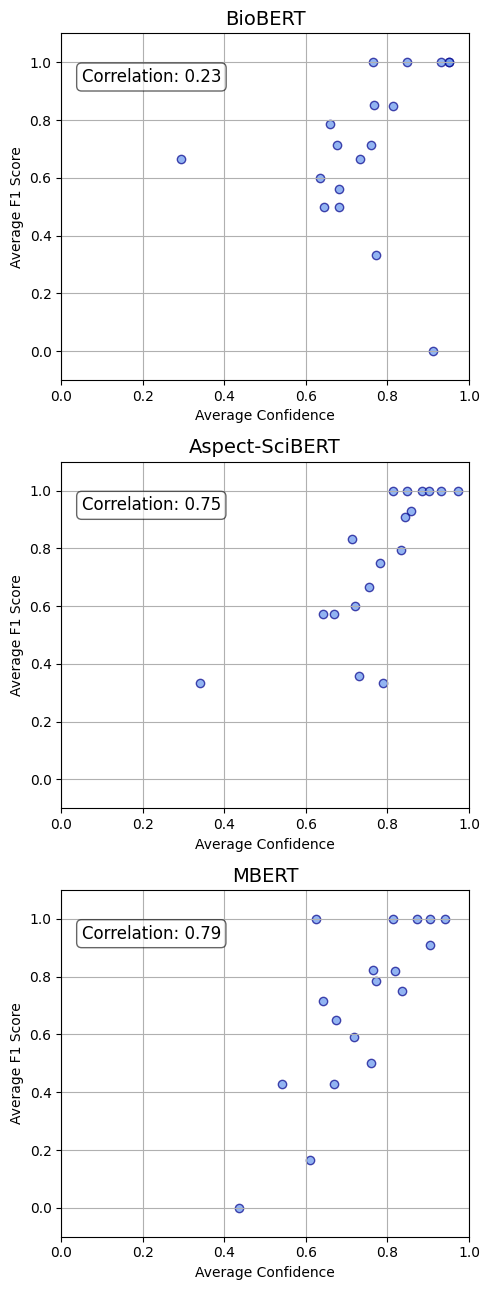

In [15]:
plot_avg_confidence_to_avg_f1(csv_files_appendix, model_names_appendix)

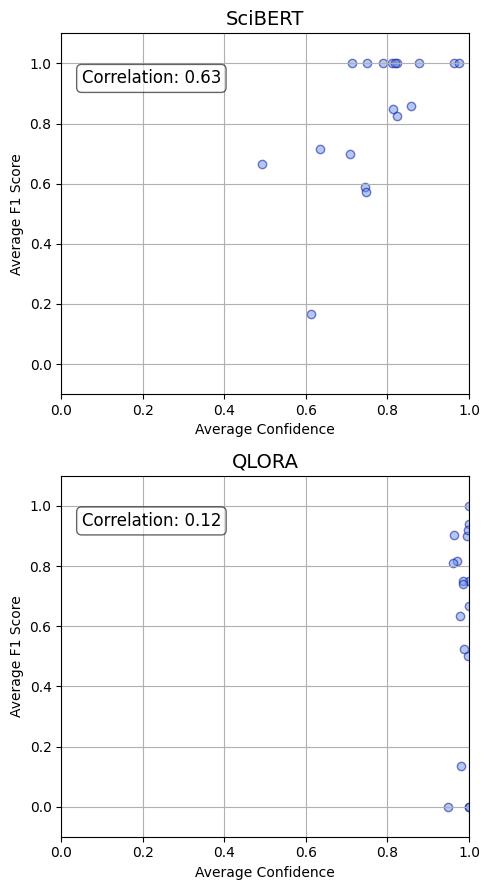

In [21]:
plot_avg_confidence_to_avg_f1(csv_files_body, model_names_body)

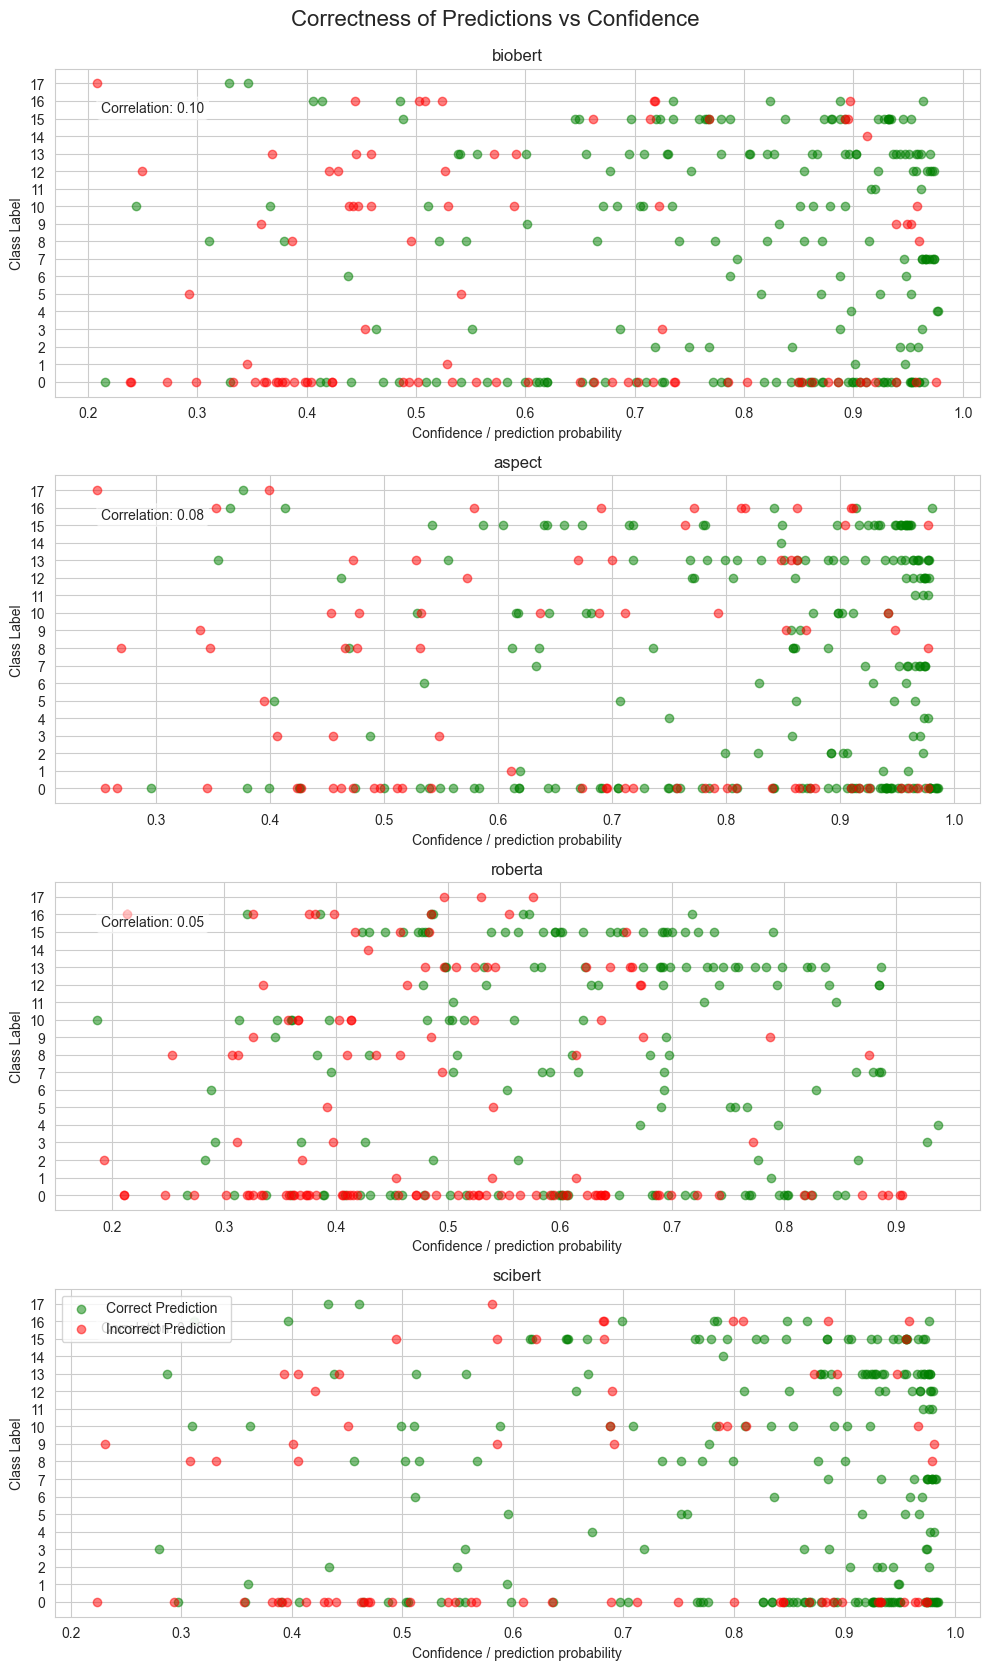

In [137]:
plot_confidence_to_performance(csv_files, model_names)

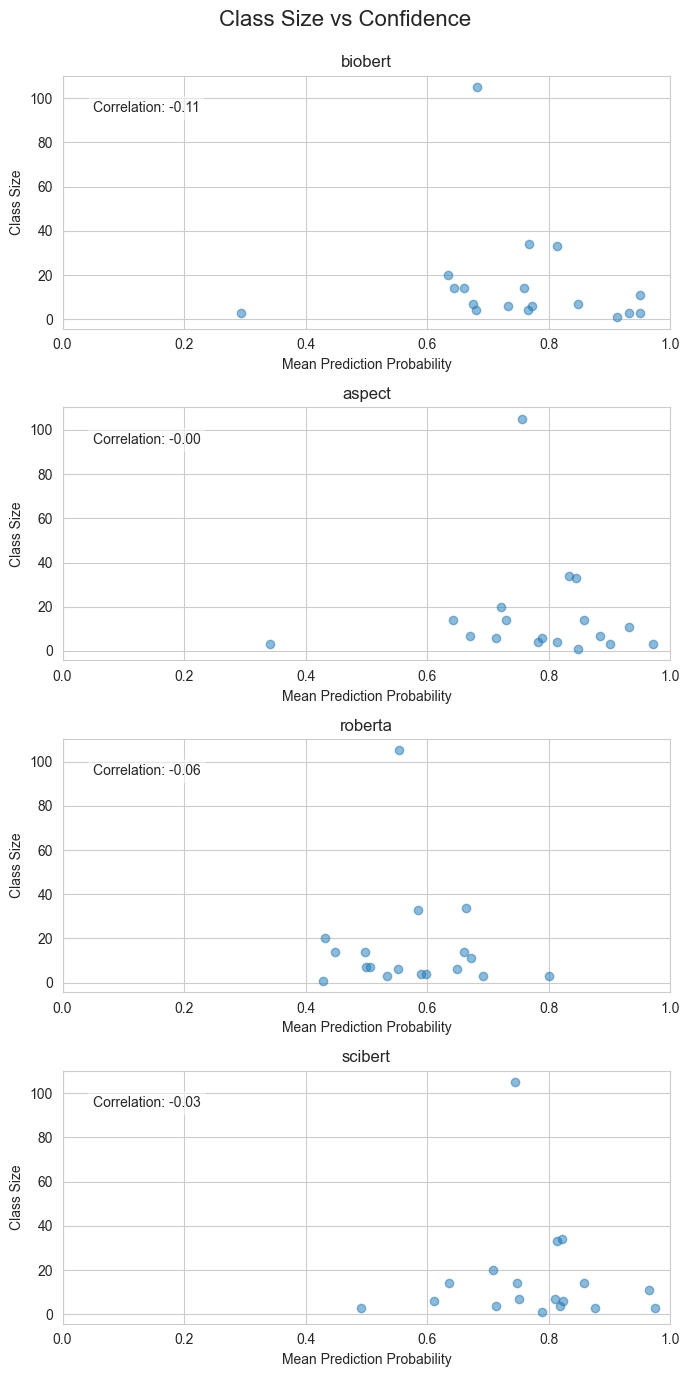

In [125]:
plot_confidence_to_size(csv_files, model_names)

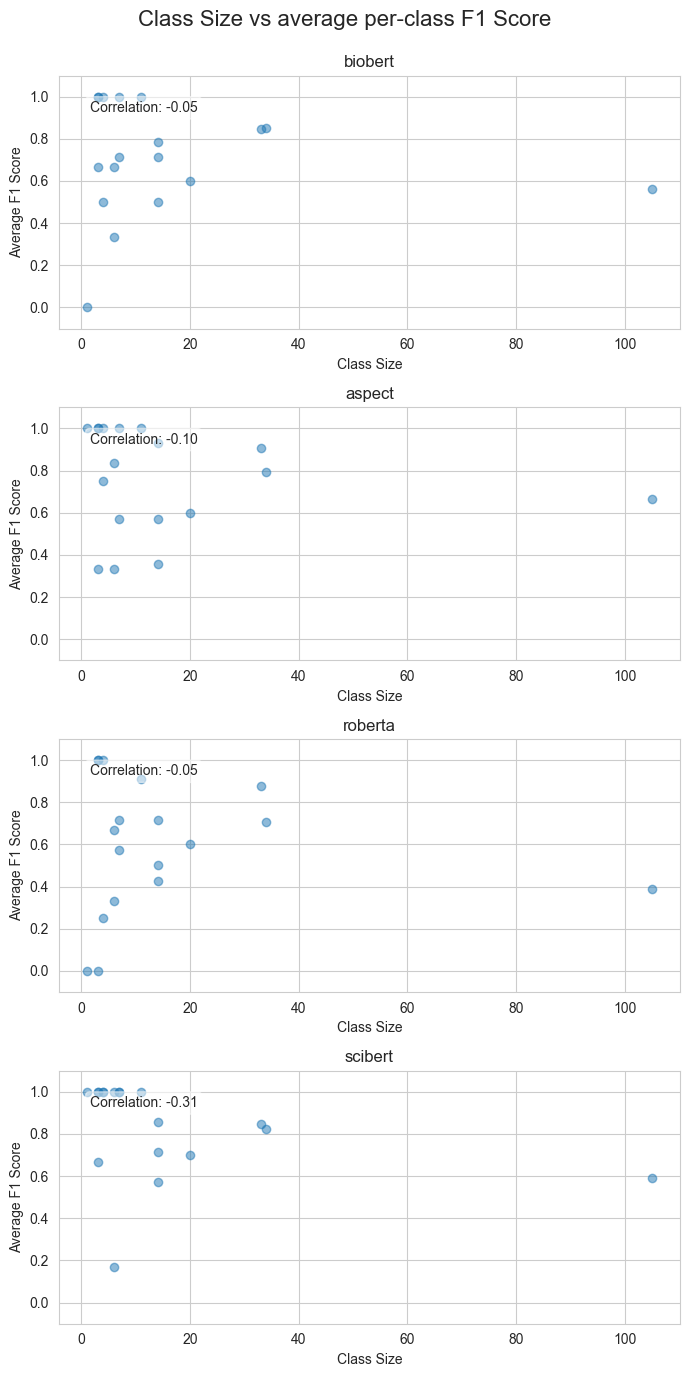

In [126]:
plot_f1_to_size(csv_files, model_names)

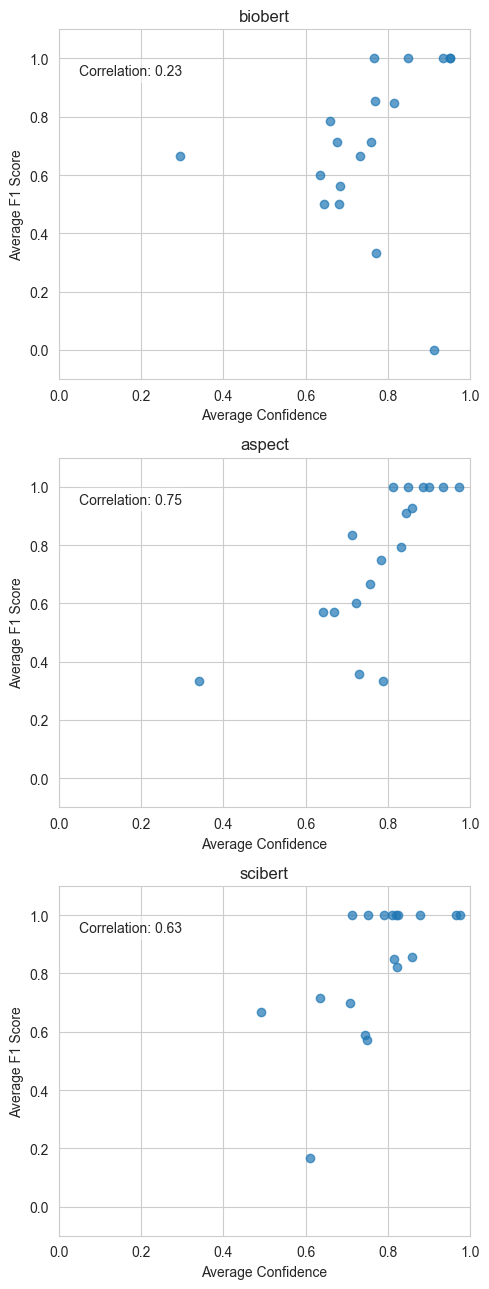